# LeNet

- 公式：output高/宽 = input高/宽 - kernel高/宽 + 1
- C1(kernel size = 5x5)：28 - 5 + 4 + 1 = 28，C1高宽为28，通道数为6，填充为2（上下左右各为2）
- S2(kernel size = 2x2)：28 / 2 = 14，通道数为6
- C3(kernel size = 5x5)：14 - 5 + 1 = 10，通道数为16
- S4(kernel size = 2x2)：10 / 2 = 5，通道数为16
- F4.5(Flatten layer 展平)：16 x 5 x 5 = 400，通道数为400，每个通道是1x1图像
- F5(线性层)：把长度为400的向量，压缩成长度为120的向量
- F6(线性层)：把长度为120的向量，压缩成长度为84的向量
- F7(线性层)：把长度为84的向量，压缩成长度为10的向量
- F8(线性层)：对长度为10的向量，做softmax回归，得到最终预测结果
- **真实零填充** = padding x 2，因为参数设置的是单边填充
    - 例：参数padding=2，表示行/列各加4，则实际padding=4
- **步幅默认为1**：（input高宽 - kernel高宽 + padding x 2 + 1）/ 1 = output高宽
- 若步幅为n：（input高宽 - kernel高宽 + padding x 2 + n）/ n = output高宽
<img src="./pic/lenet1.PNG" width=600 height=600>
- 先使用卷积层来学习图像空间信息
- 然后使用池化层降低图像灵敏度
- 最后使用全连接层转换到类别空间
<img src="./pic/lenet简化版.PNG" width=150 height=150>

## view和reshape
从功能上来看，它们的作用是相同的，都是用来重塑 Tensor 的 shape 的。view 只适合对满足连续性条件 (contiguous) 的 Tensor进行操作，而reshape 同时还可以对不满足连续性条件的 Tensor 进行操作，具有更好的鲁棒性。view 能干的 reshape都能干，如果 view 不能干就可以用 reshape 来处理。

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

# Awesome！
class Reshape(torch.nn.Module):    # 输入用
    def forward(self, x):
        return x.view(-1, 1, 28, 28)    # -1 批量数不变，通道数1，28x28

# -1代表由其他维度计算得来
# view和reshape大多情况都一样，
# reshape自动选择要不要改变内存存储方式，而view不能改变
    
net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),    # 把S4池化层（汇聚层）输出的4D张量转化为1维向量，输入到MLP。
                     # Flatten是保留第0维批量维度：相当于n个批量，每个批量是1x1图像
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [4]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

# 因为c1有padding=2，所以卷积后的图像尺寸不变
# 第一层卷积激活池化，高宽28到14，通道1到6，但实际上的信息量还是减少，而非增多
# 第二层卷积激活池化，高宽14到5，通道6到16，
# 拉长，MLP，通过hidden layers降低维度，直到输出

# 总结：卷积激活池化先升维，然后通过MLP降维，最后softmax输出

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


# FLeNet在Fashion-MNIST数据集上的表现

In [5]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

C:\Users\Tyler\anaconda3\envs\pytorch19\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 对softmax回归的evaluate_accuracy函数进行轻微的修改

- net.eval的意思是要开始进行预测了，BN等层需要eval函数进行开启，卷积不需要。大家一般习惯写上net.eval()，有时候会用到BN

- eval就是关闭模型中的dropout功能，调到评价模式；与之相对的是train()
- net.eval()是吧网络设置成评估模式，主要是在测试时固定BN层和Dropout层
- net.eval()开启验证模式，不用计算梯度和更新梯度
- eval的作用是把模型调整到验证状态，梯度清零，不调整权重

In [6]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## 为了使用GPU，我们还需要一点小改动。 与 3.6节中定义的train_epoch_ch3不同，在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上

In [9]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)    # 根据输入输出的大小，使输入输出的方差差不多
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()    # 多类分类问题（与softmax回归没区别）
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):    # 对每一个迭代的数据，拿出batch个
            timer.start()
            optimizer.zero_grad()    # 梯度设0
            X, y = X.to(device), y.to(device)    # 输入和输出挪到GPU
            y_hat = net(X)        # 前向操作forward
            l = loss(y_hat, y)    # 计算损失
            l.backward()          # 计算梯度
            optimizer.step()      # 迭代
            metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)}')
    
   # print里面红色的是显示的字，花括号里面是显示的值，.3f表示精度

loss 0.464, train acc 0.825, test acc 0.778
73396.8 examples/sec on cuda:0


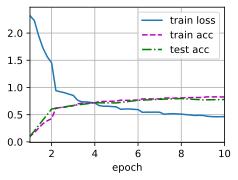

In [10]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 验证精度与训练精度大致重合

loss 0.482, train acc 0.818, test acc 0.787
78565.2 examples/sec on cuda:0


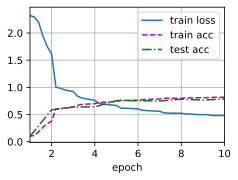

In [14]:
# 通道数由6和16，改成3和8

net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 3, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(3, 8, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(8 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

loss 0.425, train acc 0.841, test acc 0.791
87242.2 examples/sec on cuda:0


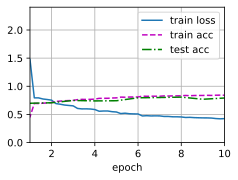

In [17]:
# sigmoid改成ReLU

net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 3, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(3, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(8 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10))

lr, num_epochs = 0.1, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [18]:
# sigmoid改成ReLU

net = nn.Sequential(
    Reshape(), nn.Conv2d(1, 3, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(3, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(), 
    nn.Linear(8 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.ReLU(),
    nn.Linear(84, 10))

lr, num_epochs = 0.1, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

RuntimeError: Trying to create tensor with negative dimension -1: [120, -1]